In [1]:
!pip install nilearn


In [94]:
# Import necessary module
import os
import re
import cv2
import glob
import shutil
import numpy as np
import nilearn
import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt
import nilearn.plotting as plotting
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install --upgrade patool

In [4]:
import zipfile
import os

# Path to the ZIP file and the extraction directory
zip_file_path = 'Atlas_2_images'
extraction_path = 'ATLAS_2_extracted'

# Run the unzip command using the '!' prefix in Google Colab
!unzip -q 'Atlas_2_images' -d 'ATLAS_2_extracted'



unzip:  cannot find or open Atlas_2_images, Atlas_2_images.zip or Atlas_2_images.ZIP.


In [13]:
import os
import random
import shutil
import glob

# Define the source directory where your files are located
data_folder = 'ATLAS_2_extracted/ATLAS_2/Training'

Data Splitting

Train:Test:Validation = 60:20:20

In [15]:
# Image and Mask files
image_files = sorted(glob.glob(os.path.join(data_folder, "**/*_T1w.nii.gz"), recursive=True))
mask_files = sorted(glob.glob(os.path.join(data_folder, "**/*_label-L_desc-T1lesion_mask.nii.gz"), recursive=True))

(197, 233, 189)


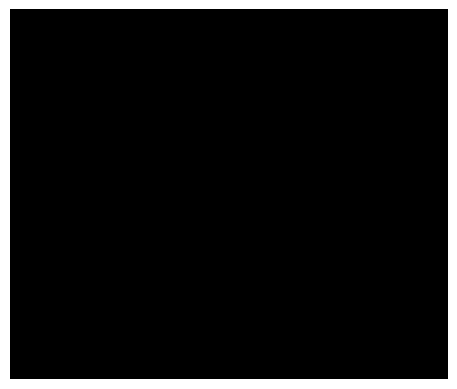

In [7]:
!pip install nilearn matplotlib
import nibabel as nib
import numpy as np

# Load your NIfTI image(s)
nifti_img = nib.load('ATLAS_2_extracted/ATLAS_2/Training/R001/sub-r001s001/ses-1/anat/sub-r001s001_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz')
data = nifti_img.get_fdata()
# Extract frames from 4D NIfTI data
print(data.shape)

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig = plt.figure()
plt.axis('off')  # Turn off axes for cleaner animation

# Function to update frames in the animation
def update_frame(frame_index):
    plt.imshow(data[:, :, frame_index], cmap='gray')  # Assuming grayscale images
    return plt

# Create animation
animation = FuncAnimation(fig, update_frame, frames=data.shape[-1], interval=100)  # Adjust interval as needed

# Display animation
from IPython.display import HTML
HTML(animation.to_jshtml())



In [20]:
image_train_files, image_test_val_files = train_test_split(image_files, test_size=0.4, random_state=42)
image_test_files, image_val_files = train_test_split(image_test_val_files, test_size=0.5, random_state=42)
mask_train_files, mask_test_val_files = train_test_split(mask_files, test_size=0.4, random_state=42)
mask_test_files, mask_val_files = train_test_split(mask_test_val_files, test_size=0.5, random_state=42)

# Train, test, and validation files
train_dir = 'train'
test_dir = 'test'
val_dir = 'val'

# Image train files
for file_name in image_train_files:
    # Load file
    file_path = file_name
    file_data = nib.load(file_path).get_fdata()

    # Load corresponding mask file
    mask_file_name = file_name.replace('_T1w.nii.gz', '_label-L_desc-T1lesion_mask.nii.gz')
    mask_file_path = mask_file_name
    mask_data = nib.load(mask_file_name).get_fdata()

    # Center of mass of the foreground mask/lesion
    center_of_mass = ndimage.center_of_mass(mask_data)

    # Define the crop size
    desired_size = (256, 256, 256)

    # Crop boundaries based on the center of mass and desired size
    x_start = int(center_of_mass[0] - desired_size[0] // 2)
    x_end = x_start + desired_size[0]
    y_start = int(center_of_mass[1] - desired_size[1] // 2)
    y_end = y_start + desired_size[1]
    z_start = int(center_of_mass[2] - desired_size[2] // 2)
    z_end = z_start + desired_size[2]

    x_start = max(0, x_start)
    x_end = min(file_data.shape[0], x_end)
    y_start = max(0, y_start)
    y_end = min(file_data.shape[1], y_end)
    z_start = max(0, z_start)
    z_end = min(file_data.shape[2], z_end)

    actual_size = (x_end - x_start, y_end - y_start, z_end - z_start)
    cropped_image = np.zeros(desired_size)
    cropped_mask = np.zeros(desired_size)
    cropped_image[:actual_size[0], :actual_size[1], :actual_size[2]] = file_data[x_start:x_end, y_start:y_end, z_start:z_end]
    cropped_mask[:actual_size[0], :actual_size[1], :actual_size[2]] = mask_data[x_start:x_end, y_start:y_end, z_start:z_end]

    image_folder = os.path.splitext(file_path)[0] + '_train_image'
    os.makedirs(os.path.join(train_dir, image_folder), exist_ok=True)
    mask_folder = os.path.splitext(mask_file_path)[0] + '_train_mask'
    os.makedirs(os.path.join(train_dir, mask_folder), exist_ok=True)

    # Normalize the data using Z-score normalization
    file_data_norm = (cropped_image - np.mean(cropped_image)) / np.std(cropped_image, ddof=1)

    # Save the cropped image as a .npy file in the image folder
    image_filename = os.path.splitext(os.path.basename(file_path))[0] + '_train_image.npy'
    image_path = os.path.join(train_dir, image_folder, image_filename)
    np.save(image_path, file_data_norm)

    # Save the cropped mask as a .npy file in the mask folder
    mask_filename = os.path.splitext(os.path.basename(mask_file_path))[0] + '_train_mask.npy'
    mask_path = os.path.join(train_dir, mask_folder, mask_filename)
    np.save(mask_path, cropped_mask)
##############################################################################################
# Test files
for file_name in image_test_files:
    # Load file
    file_path = file_name
    file_data = nib.load(file_path).get_fdata()

    # Load corresponding mask file
    mask_file_name = file_name.replace('_T1w.nii.gz', '_label-L_desc-T1lesion_mask.nii.gz')
    mask_file_path = mask_file_name
    mask_data = nib.load(mask_file_path).get_fdata()

    # Center of mass of the foreground mask/lesion
    center_of_mass = ndimage.center_of_mass(mask_data)

    # Define the desired crop size
    desired_size = (256,256,256)

    x_start = int(center_of_mass[0] - desired_size[0] // 2)
    x_end = x_start + desired_size[0]
    y_start = int(center_of_mass[1] - desired_size[1] // 2)
    y_end = y_start + desired_size[1]
    z_start = int(center_of_mass[2] - desired_size[2] // 2)
    z_end = z_start + desired_size[2]

    x_start = max(0, x_start)
    x_end = min(file_data.shape[0], x_end)
    y_start = max(0, y_start)
    y_end = min(file_data.shape[1], y_end)
    z_start = max(0, z_start)
    z_end = min(file_data.shape[2], z_end)

    actual_size = (x_end - x_start, y_end - y_start, z_end - z_start)
    cropped_image = np.zeros(desired_size)
    cropped_mask = np.zeros(desired_size)
    cropped_image[:actual_size[0], :actual_size[1], :actual_size[2]] = file_data[x_start:x_end, y_start:y_end, z_start:z_end]
    cropped_mask[:actual_size[0], :actual_size[1], :actual_size[2]] = mask_data[x_start:x_end, y_start:y_end, z_start:z_end]

    image_folder = os.path.splitext(file_path)[0] + '_test_image'
    os.makedirs(os.path.join(test_dir, image_folder), exist_ok=True)
    mask_folder = os.path.splitext(mask_file_path)[0] + '_test_mask'
    os.makedirs(os.path.join(test_dir, mask_folder), exist_ok=True)

    # Normalize data using Z-score normalization
    file_data_norm = (cropped_image - np.mean(cropped_image)) / np.std(cropped_image, ddof=1)

    # Save the cropped image as a .npy file in the image folder
    image_filename = os.path.splitext(os.path.basename(file_path))[0] + '_test_image.npy'
    image_path = os.path.join(test_dir, image_folder, image_filename)
    np.save(image_path, file_data_norm)

    # Save the cropped mask as a .npy file in the mask folder
    mask_filename = os.path.splitext(os.path.basename(mask_file_path))[0] + '_test_mask.npy'
    mask_path = os.path.join(test_dir, mask_folder, mask_filename)
    np.save(mask_path, cropped_mask)
#############################################################################################
# Validation files
for file_name in image_val_files:
    # Load file
    file_path = file_name
    file_data = nib.load(file_path).get_fdata()

    # Load corresponding mask file
    mask_file_name = file_name.replace('_T1w.nii.gz', '_label-L_desc-T1lesion_mask.nii.gz')
    mask_file_path = mask_file_name
    mask_data = nib.load(mask_file_path).get_fdata()

    # Center of mass of the foreground mask
    center_of_mass = ndimage.center_of_mass(mask_data)

    # Define the desired crop size
    desired_size = (256,256,256)

    # Calculate the crop boundaries based on the center of mass and desired size
    x_start = int(center_of_mass[0] - desired_size[0] // 2)
    x_end = x_start + desired_size[0]
    y_start = int(center_of_mass[1] - desired_size[1] // 2)
    y_end = y_start + desired_size[1]
    z_start = int(center_of_mass[2] - desired_size[2] // 2)
    z_end = z_start + desired_size[2]

    x_start = max(0, x_start)
    x_end = min(file_data.shape[0], x_end)
    y_start = max(0, y_start)
    y_end = min(file_data.shape[1], y_end)
    z_start = max(0, z_start)
    z_end = min(file_data.shape[2], z_end)

    actual_size = (x_end - x_start, y_end - y_start, z_end - z_start)
    cropped_image = np.zeros(desired_size)
    cropped_mask = np.zeros(desired_size)
    cropped_image[:actual_size[0], :actual_size[1], :actual_size[2]] = file_data[x_start:x_end, y_start:y_end, z_start:z_end]
    cropped_mask[:actual_size[0], :actual_size[1], :actual_size[2]] = mask_data[x_start:x_end, y_start:y_end, z_start:z_end]

    image_folder = os.path.splitext(file_path)[0] + '_val_image'
    os.makedirs(os.path.join(val_dir, image_folder), exist_ok=True)
    mask_folder = os.path.splitext(mask_file_path)[0] + '_val_mask'
    os.makedirs(os.path.join(val_dir, mask_folder), exist_ok=True)

    # Normalize data using Z-score normalization
    file_data_norm = (cropped_image - np.mean(cropped_image)) / np.std(cropped_image, ddof=1)

    # Save the cropped image as a .npy file in the image folder
    image_filename = os.path.splitext(os.path.basename(file_path))[0] + '_val_image.npy'
    image_path = os.path.join(val_dir, image_folder, image_filename)
    np.save(image_path, file_data_norm)

    # Save the cropped mask as a .npy file in the mask folder
    mask_filename = os.path.splitext(os.path.basename(mask_file_path))[0] + '_val_mask.npy'
    mask_path = os.path.join(val_dir, mask_folder, mask_filename)
    np.save(mask_path, cropped_mask)

In [87]:
import os
image_npy_files_train = sorted(glob.glob(os.path.join(data_folder, "**/*_T1w.nii_train_image.npy"), recursive=True))
mask_npy_files_train = sorted(glob.glob(os.path.join(data_folder, "**/*_mask.nii_train_mask.npy"), recursive=True))

image_npy_files_test = sorted(glob.glob(os.path.join(data_folder, "**/*_T1w.nii_test_image.npy"), recursive=True))
mask_npy_files_test = sorted(glob.glob(os.path.join(data_folder, "**/*_mask.nii_test_mask.npy"), recursive=True))

image_npy_files_val = sorted(glob.glob(os.path.join(data_folder, "**/*_T1w.nii_val_image.npy"), recursive=True))
mask_npy_files_val = sorted(glob.glob(os.path.join(data_folder, "**/*_mask.nii_val_mask.npy"), recursive=True))

print("Image .npy files:", len(image_npy_files_train))
print("Mask .npy files:", len(mask_npy_files_train))

print("Image .npy files:", len(image_npy_files_test))
print("Mask .npy files:", len(mask_npy_files_test))

print("Image .npy files:", len(image_npy_files_val))
print("Mask .npy files:", len(mask_npy_files_val))

Image .npy files: 462
Mask .npy files: 155
Image .npy files: 153
Mask .npy files: 51
Image .npy files: 156
Mask .npy files: 52


In [23]:
# Train
train_image_folder = os.path.join(data_folder, "train", "images")
train_mask_folder = os.path.join(data_folder, "train", "masks")

if not os.path.exists(train_image_folder):
    os.makedirs(train_image_folder)
if not os.path.exists(train_mask_folder):
    os.makedirs(train_mask_folder)

# train/images and train/masks
for i in range(len(image_npy_files_train)):
    image_path = image_npy_files_train[i]
    mask_path = mask_npy_files_train[i]
    file_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(train_image_folder, file_name))
    shutil.copy(mask_path, os.path.join(train_mask_folder, file_name))

test_image_folder = os.path.join(data_folder, "test", "images")
test_mask_folder = os.path.join(data_folder, "test", "masks")
if not os.path.exists(test_image_folder):
    os.makedirs(test_image_folder)
if not os.path.exists(test_mask_folder):
    os.makedirs(test_mask_folder)

# test/images and test/masks
for i in range(len(image_npy_files_test)):
    image_path = image_npy_files_test[i]
    mask_path = mask_npy_files_test[i]
    file_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(test_image_folder, file_name))
    shutil.copy(mask_path, os.path.join(test_mask_folder, file_name))

val_image_folder = os.path.join(data_folder, "val", "images")
val_mask_folder = os.path.join(data_folder, "val", "masks")

if not os.path.exists(val_image_folder):
    os.makedirs(val_image_folder)
if not os.path.exists(val_mask_folder):
    os.makedirs(val_mask_folder)

# val/images and val/masks
for i in range(len(image_npy_files_val)):
    image_path = image_npy_files_val[i]
    mask_path = mask_npy_files_val[i]
    file_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(val_image_folder, file_name))
    shutil.copy(mask_path, os.path.join(val_mask_folder, file_name))

In [103]:
# Train folder
train_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/train/images/"
train_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/train/masks/"

num_images = len(os.listdir(train_image_folder))
num_masks = len(os.listdir(train_mask_folder))

print("Number of images in train/images:", num_images)
print("Number of masks in train/masks:", num_masks)

# Test Folder
test_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/test/images/"
test_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/test/masks/"

num_images = len(os.listdir(test_image_folder))
num_masks = len(os.listdir(test_mask_folder))

print("Number of images in test/images:", num_images)
print("Number of masks in test/masks:", num_masks)

# Validation Folder
val_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/val/images/"
val_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/val/masks/"

num_images = len(os.listdir(val_image_folder))
num_masks = len(os.listdir(val_mask_folder))

print("Number of images in val/images:", num_images)
print("Number of masks in val/masks:", num_masks)

Number of images in train/images: 154
Number of masks in train/masks: 154
Number of images in test/images: 51
Number of masks in test/masks: 51
Number of images in val/images: 52
Number of masks in val/masks: 52


Sample images from the train directory:


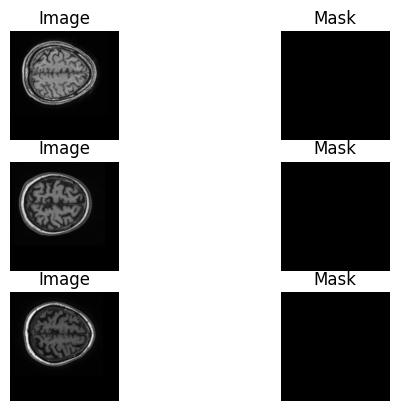

Sample images from the test directory:


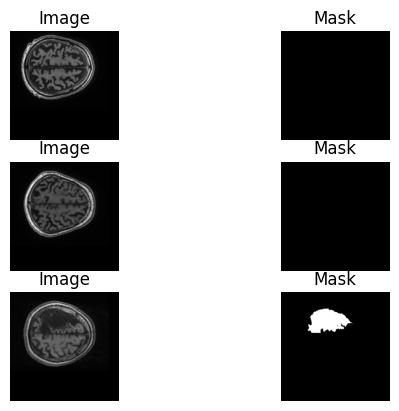

Sample images from the validation directory:


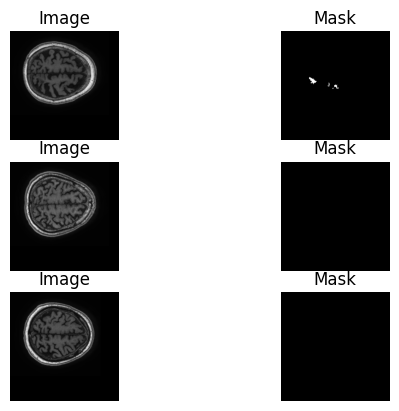

In [89]:
import numpy as np
import os
import matplotlib.pyplot as plt

def display_sample_images(image_folder, mask_folder, num_samples=3):
    image_files = os.listdir(image_folder)[:num_samples]
    mask_files = os.listdir(mask_folder)[:num_samples]

    for i in range(num_samples):
        image_path = os.path.join(image_folder, image_files[i])
        mask_path = os.path.join(mask_folder, mask_files[i])

        # Load and display the image
        image = np.load(image_path)
        if image.ndim == 3:  # Check if image is 3D
            # If the image is 3D, take the middle slice
            image = image[:, :, image.shape[2] // 2]
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(image, cmap='gray')  # Assuming grayscale images
        plt.axis('off')
        plt.title('Image')

        # Load and display the mask
        mask = np.load(mask_path)
        if mask.ndim == 3:  # Check if mask is 3D
            # If the mask is 3D, take the middle slice
            mask = mask[:, :, mask.shape[2] // 2]
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title('Mask')

    plt.show()

# Train folder
train_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/train/images/"
train_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/train/masks/"

# Test Folder
test_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/test/images/"
test_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/test/masks/"

# Validation Folder
val_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/val/images/"
val_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/val/masks/"

# Display sample images from the train directory
print("Sample images from the train directory:")
display_sample_images(train_image_folder, train_mask_folder)

# Display sample images from the test directory
print("Sample images from the test directory:")
display_sample_images(test_image_folder, test_mask_folder)

# Display sample images from the validation directory
print("Sample images from the validation directory:")
display_sample_images(val_image_folder, val_mask_folder)

In [26]:
import numpy as np
import glob

# Define the paths to your data directories
# Train folder
train_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/train/images/"
train_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/train/masks/"

# Test Folder
test_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/test/images/"
test_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/test/masks/"

# Validation Folder
val_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/val/images/"
val_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/val/masks/"

# Load training data
train_image_files = glob.glob(train_image_folder + '/**/*_T1w.nii_train_image.npy', recursive=True)
train_mask_files = glob.glob(train_mask_folder + '/**/*_mask.nii_train_mask.npy', recursive=True)
X_train = [np.load(file) for file in train_image_files]
y_train = [np.load(file) for file in train_mask_files]

# Load testing data
test_image_files = glob.glob(test_image_folder + '/**/*_T1w.nii_test_image.npy', recursive=True)
test_mask_files = glob.glob(test_mask_folder + '/**/*_mask.nii_test_mask.npy', recursive=True)
X_test = [np.load(file) for file in test_image_files]
y_test = [np.load(file) for file in test_mask_files]

# Load validation data
val_image_files = glob.glob(val_image_folder + '/**/*_T1w.nii_val_image.npy', recursive=True)
val_mask_files = glob.glob(val_mask_folder + '/**/*_mask.nii_val_mask.npy', recursive=True)
X_val = [np.load(file) for file in val_image_files]
y_val = [np.load(file) for file in val_mask_files]


In [29]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 5.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 97.6 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 KB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 KB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 102.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 KB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.7 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 57.6 MB/s e

In [90]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, Dropout

def unet_3d(input_shape=(256, 256, 256, 1), num_classes=1):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    # Expansive path
    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv4], axis=4)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), conv3], axis=4)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=4)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=4)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = unet_3d(input_shape=(256, 256, 256, 1), num_classes=1)
model.summary()


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 256, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_418 (Conv3D) │ (None, 256, 256,  │        896 │ input_layer_22[0… │
│                     │ 256, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_419 (Conv3D) │ (None, 256, 256,  │     27,680 │ conv3d_418[0][0]  │
│                     │ 256, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_88    │ (None, 128, 128,  │          0 │ conv3d_419[0][0]  │
│ (MaxPooling3D)      │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_420 (Conv3D) │ (None, 128, 128,  │     55,360 │ max_pooling3d_88… │
│                     │ 128, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_421 (Conv3D) │ (None, 128, 128,  │    110,656 │ conv3d_420[0][0]  │
│                     │ 128, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_89    │ (None, 64, 64,    │          0 │ conv3d_421[0][0]  │
│ (MaxPooling3D)      │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_422 (Conv3D) │ (None, 64, 64,    │    221,312 │ max_pooling3d_89… │
│                     │ 64, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_423 (Conv3D) │ (None, 64, 64,    │    442,496 │ conv3d_422[0][0]  │
│                     │ 64, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_90    │ (None, 32, 32,    │          0 │ conv3d_423[0][0]  │
│ (MaxPooling3D)      │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_424 (Conv3D) │ (None, 32, 32,    │    884,992 │ max_pooling3d_90… │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_425 (Conv3D) │ (None, 32, 32,    │  1,769,728 │ conv3d_424[0][0]  │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_91    │ (None, 16, 16,    │          0 │ conv3d_425[0][0]  │
│ (MaxPooling3D)      │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_426 (Conv3D) │ (None, 16, 16,    │  3,539,456 │ max_pooling3d_91… │
│                     │ 16, 512)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_427 (Conv3D) │ (None, 16, 16,    │  7,078,400 │ conv3d_426[0][0]  │
│                     │ 16, 512)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_88 │ (None, 32, 32,    │  1,048,832 │ conv3d_427[0][0]  │
│ (Conv3DTranspose)   │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_88      │ (None, 32, 32,    │          0 │ conv3d_transpose

 Total params: 22,575,329 (86.12 MB)

 Trainable params: 22,575,329 (86.12 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
import glob
import numpy as np
# Train folder
train_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/train/images/"
train_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/train/masks/"

# Test Folder
test_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/test/images/"
test_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/test/masks/"

# Validation Folder
val_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/val/images/"
val_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/val/masks/"

# Load training data
train_image_files = glob.glob(train_image_folder + '/**/*_T1w.nii_train_image.npy', recursive=True)
train_mask_files = glob.glob(train_mask_folder + '/**/*_mask.nii_train_mask.npy', recursive=True)
X_train = [np.load(file) for file in train_image_files]
y_train = [np.load(file) for file in train_mask_files]
print(len(X_train))
# Load testing data
test_image_files = glob.glob(test_image_folder + '/**/*_T1w.nii_test_image.npy', recursive=True)
test_mask_files = glob.glob(test_mask_folder + '/**/*_mask.nii_test_mask.npy', recursive=True)
X_test = [np.load(file) for file in test_image_files]
y_test = [np.load(file) for file in test_mask_files]

# Load validation data
val_image_files = glob.glob(val_image_folder + '/**/*_T1w.nii_val_image.npy', recursive=True)
val_mask_files = glob.glob(val_mask_folder + '/**/*_mask.nii_test_mask.npy', recursive=True)
X_val = [np.load(file) for file in val_image_files]
y_val = [np.load(file) for file in val_mask_files]

154


In [105]:
# Train folder
train_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/train/images/"
train_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/train/masks/"

num_images = len(os.listdir(train_image_folder))
num_masks = len(os.listdir(train_mask_folder))

print("Number of images in train/images:", num_images)
print("Number of masks in train/masks:", num_masks)

# Test Folder
test_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/test/images/"
test_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/test/masks/"

num_images = len(os.listdir(test_image_folder))
num_masks = len(os.listdir(test_mask_folder))

print("Number of images in test/images:", num_images)
print("Number of masks in test/masks:", num_masks)

# Validation Folder
val_image_folder = "ATLAS_2_extracted/ATLAS_2/Training/val/images/"
val_mask_folder = "ATLAS_2_extracted/ATLAS_2/Training/val/masks/"

num_images = len(os.listdir(val_image_folder))
num_masks = len(os.listdir(val_mask_folder))

print("Number of images in val/images:", num_images)
print("Number of masks in val/masks:", num_masks)

Number of images in train/images: 154
Number of masks in train/masks: 154
Number of images in test/images: 51
Number of masks in test/masks: 51
Number of images in val/images: 52
Number of masks in val/masks: 52


In [78]:
import os
import csv

# Directories
train_dir = 'ATLAS_2_extracted/ATLAS_2/Training/train'
test_dir = 'ATLAS_2_extracted/ATLAS_2/Training/test'
val_dir = 'ATLAS_2_extracted/ATLAS_2/Training/val'

# Initialize lists to store file paths
train_image_paths = []
train_mask_paths = []
test_image_paths = []
test_mask_paths = []
val_image_paths = []
val_mask_paths = []

# Function to iterate through directories and collect file paths
def collect_paths(image_dir, mask_dir, image_paths, mask_paths):
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith('.npy'):
                image_paths.append(os.path.join(root, file))
                corresponding_mask = os.path.join(mask_dir, os.path.basename(root), file.replace('_image.npy', '_image.npy'))
                mask_paths.append(corresponding_mask)

# Collect paths for train set
collect_paths(train_dir, train_dir, train_image_paths, train_mask_paths)

# Collect paths for test set
collect_paths(test_dir, test_dir, test_image_paths, test_mask_paths)

# Collect paths for validation set
collect_paths(val_dir, val_dir, val_image_paths, val_mask_paths)

# Function to write paths to CSV file
def write_to_csv(image_paths, mask_paths, csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['image_path', 'mask_path'])
        for img_path, mask_path in zip(image_paths, mask_paths):
            writer.writerow([img_path, mask_path])

# Write train paths to CSV
write_to_csv(train_image_paths, train_mask_paths, 'train_paths.csv')

# Write test paths to CSV
write_to_csv(test_image_paths, test_mask_paths, 'test_paths.csv')

# Write validation paths to CSV
write_to_csv(val_image_paths, val_mask_paths, 'val_paths.csv')



In [80]:
!pip install gpustat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 KB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 KB 14.9 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.1.1-py3-none-any.whl size=26532 sha256=d9148a3055c5b61a0f892c48afe95df18ca9759b0ae80a394d51e592b469c4fa
  Stored in directory: /home/tanondi/.cache/pip/wheels/ec/d7/80/a71ba3540900e1f276bcae685efd8e590c810d2108b95f1e47
Successfully built gpustat


In [76]:
!pip install pandas
import pandas as pd

In [98]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Specify the GPU ID you want to use, e.g., "0" for GPU 0


In [110]:

import numpy as np

def data_generator(image_paths, mask_paths, batch_size):
    num_samples = len(image_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_image_paths = image_paths[offset:offset+batch_size]
            batch_mask_paths = mask_paths[offset:offset+batch_size]
            images = []
            masks = []
            for image_path, mask_path in zip(batch_image_paths, batch_mask_paths):
                # Load and preprocess images
                image_data = np.load(image_path)
                mask_data = np.load(mask_path)
                images.append(image_data)
                masks.append(mask_data)
            yield np.array(images), np.array(masks)


# Load paths from CSV file
train_df = pd.read_csv('train_paths.csv')
test_df = pd.read_csv('test_paths.csv')
val_df = pd.read_csv('val_paths.csv')

# Extract image and mask paths
train_image_paths = train_df['image_path'].values
train_mask_paths = train_df['mask_path'].values
test_image_paths = test_df['image_path'].values
test_mask_paths = test_df['mask_path'].values
val_image_paths = val_df['image_path'].values
val_mask_paths = val_df['mask_path'].values

# Define model
input_shape = (256, 256, 256, 1)
model = unet_3d(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Define batch size and number of epochs
batch_size = 4
epochs = 5

# Train the model using the custom data generator
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

train_generator = data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = data_generator(val_image_paths, val_mask_paths, batch_size)

history = model.fit(train_generator, 
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch)

# Evaluate the model on the test set
test_generator = data_generator(test_image_paths, test_mask_paths, batch_size)
test_steps = len(test_image_paths) // batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/5
11/77 ━━━━━━━━━━━━━━━━━━━━ 18:56:22 1033s/step - accuracy: 0.9030 - loss: 0.6748

2024-04-26 03:36:56.864157: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: EOFError: No data left in file
Traceback (most recent call last):

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/keras/src/trainers/data_adapters/generator_data_adapter.py", line 52, in get_tf_iterator
    for batch in self.generator:

  File "/tmp/ipykernel_60912/172900374.py", line 13, in data_generator
    image_data =

12/77 ━━━━━━━━━━━━━━━━━━━━ 18:38:56 1033s/step - accuracy: 0.9085 - loss: 0.6636

2024-04-26 03:54:07.686289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: UNKNOWN: EOFError: No data left in file
Traceback (most recent call last):

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/keras/src/trainers/data_adapters/generator_data_adapter.py", line 52, in get_tf_iterator
    for batch in self.generator:

  File "/tmp/ipykernel_60912/172900374.

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
EOFError: No data left in file
Traceback (most recent call last):

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/keras/src/trainers/data_adapters/generator_data_adapter.py", line 52, in get_tf_iterator
    for batch in self.generator:

  File "/tmp/ipykernel_60912/172900374.py", line 13, in data_generator
    image_data = np.load(image_path)

  File "/data/tanondi/tanondi_ATLAS/tanondi_ATLAS/lib/python3.10/site-packages/numpy/lib/npyio.py", line 436, in load
    raise EOFError("No data left in file")

EOFError: No data left in file


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_56614]

In [109]:
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate
from tensorflow.keras.models import Model

def conv_block(inputs, filters, kernel_size=(3, 3, 3), activation='relu', padding='same'):
    x = Conv3D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    x = Conv3D(filters, kernel_size, activation=activation, padding=padding)(x)
    return x

def unet_3d(input_shape=(256, 256, 256, 1)):
    # Input
    inputs = Input(input_shape)

    # Encoder
    conv1 = conv_block(inputs, 32)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = conv_block(pool3, 256)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    # Bridge
    conv5 = conv_block(pool4, 512)

    # Decoder
    up6 = UpSampling3D(size=(2, 2, 2))(conv5)
    concat6 = concatenate([up6, conv4], axis=-1)
    conv6 = conv_block(concat6, 256)

    up7 = UpSampling3D(size=(2, 2, 2))(conv6)
    concat7 = concatenate([up7, conv3], axis=-1)
    conv7 = conv_block(concat7, 128)

    up8 = UpSampling3D(size=(2, 2, 2))(conv7)
    concat8 = concatenate([up8, conv2], axis=-1)
    conv8 = conv_block(concat8, 64)

    up9 = UpSampling3D(size=(2, 2, 2))(conv8)
    concat9 = concatenate([up9, conv1], axis=-1)
    conv9 = conv_block(concat9, 32)

    # Output
    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)

    # Model
    model = Model(inputs, outputs)
    return model

# Create the model
input_shape = (256, 256, 256, 1)
model = unet_3d(input_shape)

# Print model summary
model.summary()


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 256, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_494 (Conv3D) │ (None, 256, 256,  │        896 │ input_layer_30[0… │
│                     │ 256, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_495 (Conv3D) │ (None, 256, 256,  │     27,680 │ conv3d_494[0][0]  │
│                     │ 256, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_104   │ (None, 128, 128,  │          0 │ conv3d_495[0][0]  │
│ (MaxPooling3D)      │ 128, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_496 (Conv3D) │ (None, 128, 128,  │     55,360 │ max_pooling3d_10… │
│                     │ 128, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_497 (Conv3D) │ (None, 128, 128,  │    110,656 │ conv3d_496[0][0]  │
│                     │ 128, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_105   │ (None, 64, 64,    │          0 │ conv3d_497[0][0]  │
│ (MaxPooling3D)      │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_498 (Conv3D) │ (None, 64, 64,    │    221,312 │ max_pooling3d_10… │
│                     │ 64, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_499 (Conv3D) │ (None, 64, 64,    │    442,496 │ conv3d_498[0][0]  │
│                     │ 64, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_106   │ (None, 32, 32,    │          0 │ conv3d_499[0][0]  │
│ (MaxPooling3D)      │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_500 (Conv3D) │ (None, 32, 32,    │    884,992 │ max_pooling3d_10… │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_501 (Conv3D) │ (None, 32, 32,    │  1,769,728 │ conv3d_500[0][0]  │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_107   │ (None, 16, 16,    │          0 │ conv3d_501[0][0]  │
│ (MaxPooling3D)      │ 16, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_502 (Conv3D) │ (None, 16, 16,    │  3,539,456 │ max_pooling3d_10… │
│                     │ 16, 512)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_503 (Conv3D) │ (None, 16, 16,    │  7,078,400 │ conv3d_502[0][0]  │
│                     │ 16, 512)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d       │ (None, 32, 32,    │          0 │ conv3d_503[0][0]  │
│ (UpSampling3D)      │ 32, 512)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_104     │ (None, 32, 32,    │          0 │ up_sampling3d[0]

 Total params: 23,532,289 (89.77 MB)

 Trainable params: 23,532,289 (89.77 MB)

 Non-trainable params: 0 (0.00 B)